In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer,pipeline,LogitsProcessor
import torch
import torch
import torchaudio
import torchgen
import torchvision
# import bitsandbytes
import accelerate
from torch.nn import functional as F
from torch.nn.functional import softmax
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import time
import warnings
warnings.filterwarnings("ignore")
from transformers.utils import logging
logging.set_verbosity_error()  

# Notebook: Testing Ollama Functionality

**Objective.** Generate event outcome probabilities and investigate the market events prediction probabilities generated by the 3.2B Model
**Key Results.** 
- Models with less no of parameters (like 3.2B) have issues relating to prompt conditioning caused by Date‑conditioning leak, Instruction drift ,Contradiction.
- Test out models with more parameters, quantized versions to confirm use case requirement

In [2]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16,device_map = 'auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#  Fact Checking

In [8]:

def generate_fact_prompt(question,date):
    message = [
    {
    "role": "system",
    "content": 
        f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
    },
    {"role": "user", "content": f"{question}? Answer in a single Word: Yes or No only."}
    ]
    return message

In [9]:
questions = ['Is Queen Elizabeth II alive today?','Is Nancy Pelosi the Speaker of the U.S House of Representatives today?','Is Mike Johnson the Speaker of the U.S House of Representatives today?'
             "Is Kevin McCarthy the Speaker of the U.S House of Representatives today?","Did an earthquake occur in Turkey this Month?",
             "Did Argentina win the FIFA World Cup?"]
events_dates = ["2022-09-22","2023-01-03","2023-10-25","2023-01-03","2023-02-01","2022-12-18"]

In [10]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 1)
current_date = start_date
date_strs = []
while current_date <= end_date:
    date_strs.append(current_date.strftime("%Y-%m-%d"))
    current_date += relativedelta(months=1)

In [11]:
fact_df = pd.DataFrame(columns=['date','question','yes','no','inference_time','event_date'])
fact_df = fact_df.set_index(['question','date'])

In [17]:

for event_date,question in zip(events_dates,questions):
    # fact_df.loc[question,"event_date"] = event_date
    for date_str in date_strs:
        prompt = generate_fact_prompt(question,date_str)
        prompt_ids = tokenizer.apply_chat_template(
                prompt,
                add_generation_prompt=True,          
                return_tensors="pt"
                ).to(model.device)
        st = time.time()
        outputs = model.generate(prompt_ids, max_new_tokens=20,
                                 do_sample=False, 
                                temperature=0.0,
                                return_dict_in_generate=True,
                                output_scores=True)
        # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
        fact_df.loc[(question, date_str),'inference_time'] = time.time() - st
  
        probs   = torch.softmax(outputs.scores[0], dim=-1).flatten()
        # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
        # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
        #     for w in ["Yes", "No"]})
        fact_df.loc[(question, date_str),"event_date"] = event_date
        fact_df.loc[(question, date_str),"yes"] = float(probs[tokenizer.encode("Yes", add_special_tokens=False)[0]])
        fact_df.loc[(question, date_str),"no"] = float(probs[tokenizer.encode("No", add_special_tokens=False)[0]])
            # print(f"Question: {question} | Date: {date_str} | Response: {response}")

In [18]:
fact_df

yes        no  \
question                              date                             
Is Queen Elizabeth II alive today?    2021-01-01  0.003172  0.996578   
                                      2021-02-01  0.005909  0.993796   
                                      2021-03-01  0.006691  0.992998   
                                      2021-04-01  0.005219  0.994496   
                                      2021-05-01  0.005909  0.993787   
...                                                    ...       ...   
Did Argentina win the FIFA World Cup? 2023-08-01  0.004068  0.995496   
                                      2023-09-01  0.004068  0.995491   
                                      2023-10-01  0.004068  0.995519   
                                      2023-11-01  0.003592  0.995995   
                                      2023-12-01  0.003171  0.996451   

                                                 inference_time  event_date  
question                              date                                   
Is Queen Elizabeth II alive today?    2021-01-01       0.481473  2022-09-22  
                                      2021-02-01       0.344553  2022-09-22  
                                      2021-03-01       0.347183  2022-09-22  
                                      2021-04-01       0.346069  2022-09-22  
                                      2021-05-01       0.347681  2022-09-22  
...                                                         ...         ...  
Did Argentina win the FIFA World Cup? 2023-08-01       0.347767  2023-02-01  
                                      2023-09-01       0.352355  2023-02-01  
                                      2023-10-01       0.352409  2023-02-01  
                                      2023-11-01       0.357739  2023-02-01  
                                      2023-12-01       0.353954  2023-02-01  

[180 rows x 4 columns]

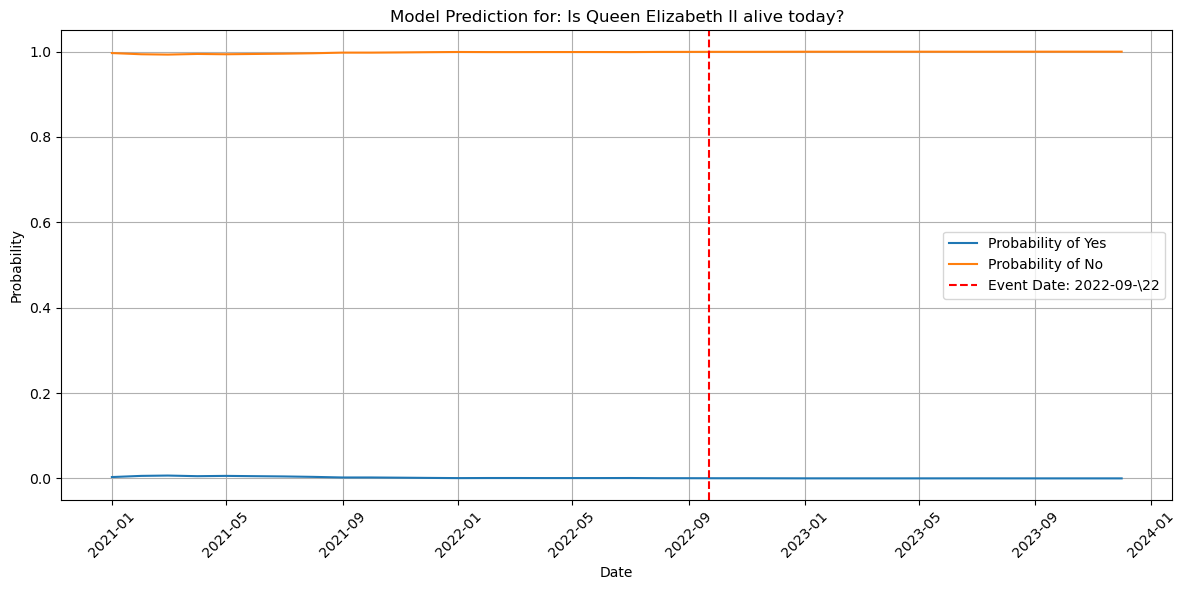

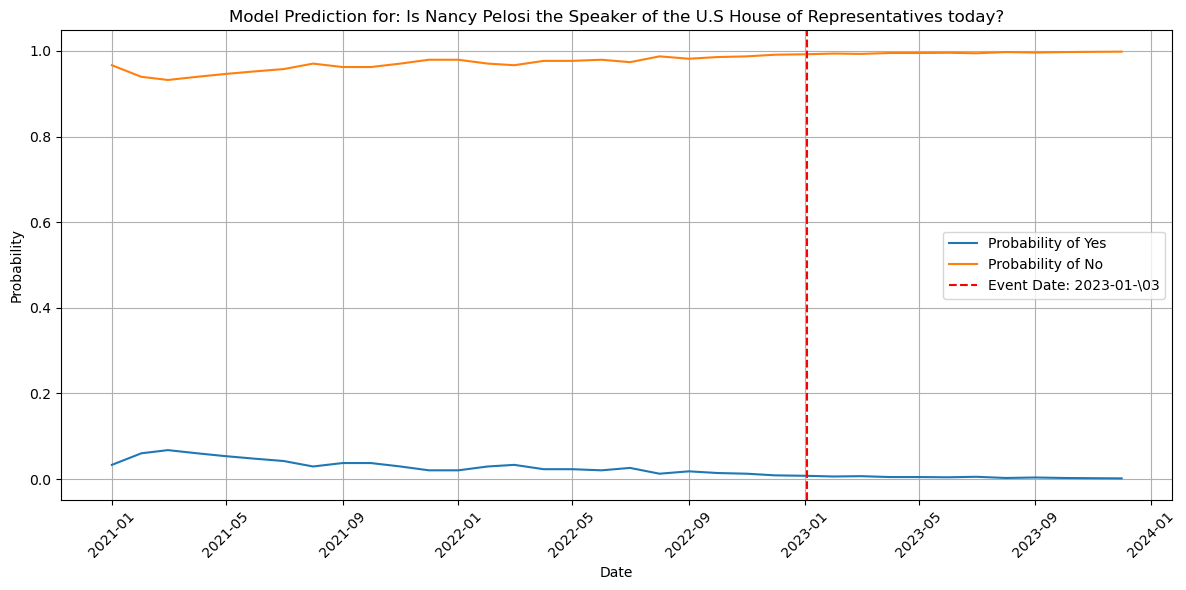

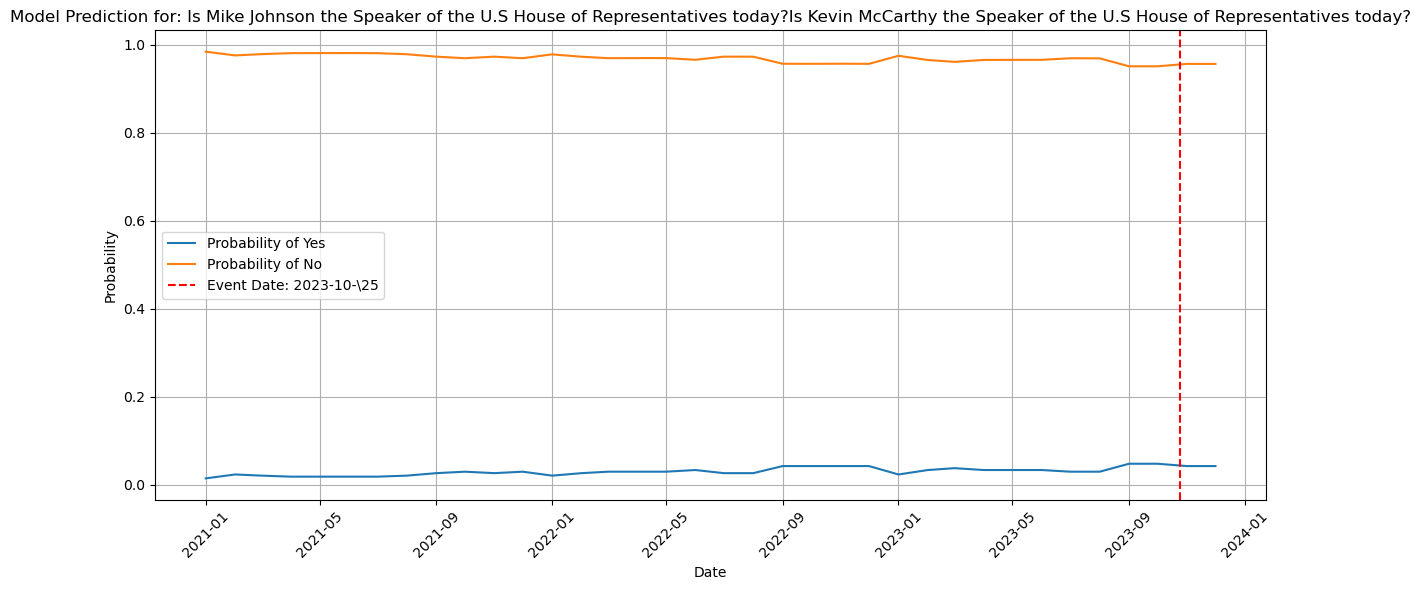

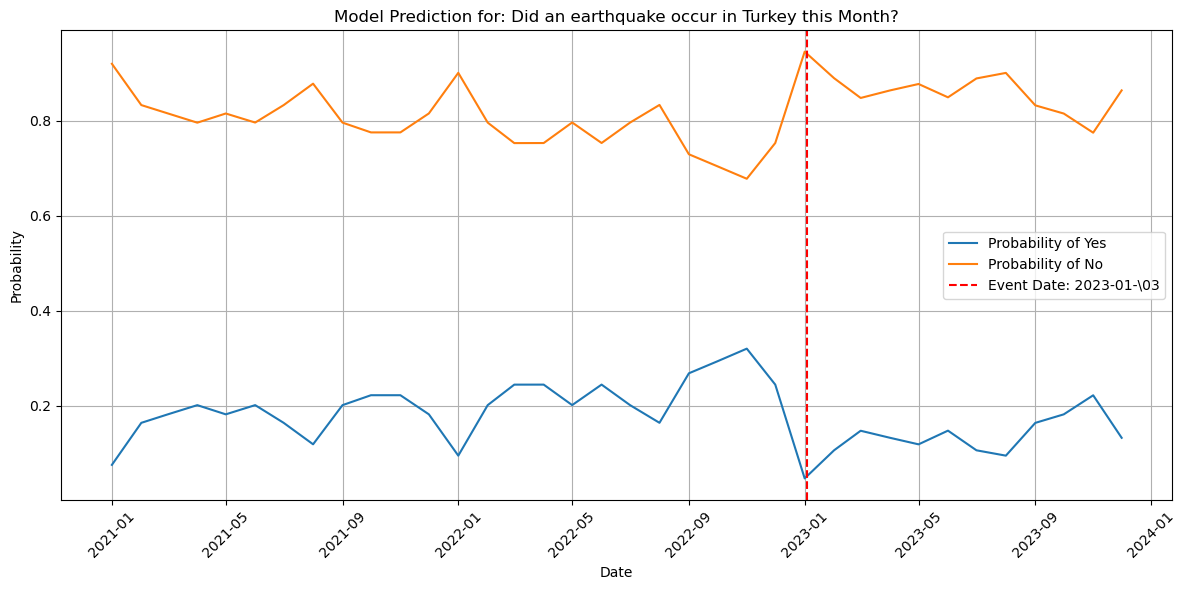

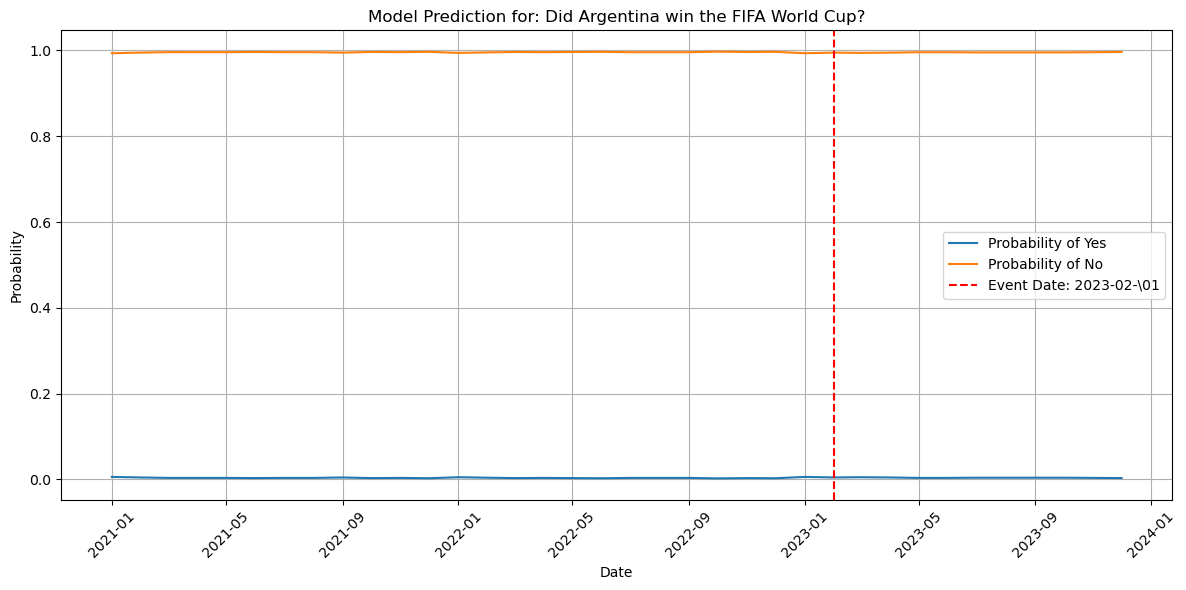

In [19]:
fact_df.index = fact_df.index.set_levels(pd.to_datetime(fact_df.index.levels[1]), level='date')


fact_df['event_date'] = pd.to_datetime(fact_df['event_date'])



unique_questions = fact_df.index.get_level_values('question').unique()
for question in unique_questions:
    question_df = fact_df.loc[question]
    plt.figure(figsize=(12, 6))
    plt.plot(question_df.index, question_df['yes'], label='Probability of Yes')
    plt.plot(question_df.index, question_df['no'], label='Probability of No')

    # Get the event date for the current question
    event_date = question_df['event_date'].iloc[0]
    plt.axvline(x=event_date, color='r', linestyle='--', label=f'Event Date: {event_date.strftime("%Y-%m-\%d")}')

    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.title(f'Model Prediction for: {question}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Cut of Date for LLama 3.2-3B is Dec 2023
## Reasons for no variance in predictions, is basically a mixture of below factors
1) Date‑conditioning leak – System messages are only weak guidance; the model’s much stronger long‑term knowledge overrules the pretend “today.


2) Contradiction – claims Pelosi isn’t Speaker and cites McCarthy months early.	3 B parameters ≈ weak factual resolution; it conflates late‑2022 events with early‑2023 events

# Fact Checking 2 

In [20]:
def generate_fact_prompt_2(question,date):
    message = [
    {
    "role": "system",
    "content": 
        f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
    },
    {"role": "user", "content": f"Today is {date}. {question}? Answer in a single Word: Yes or No only."}
    ]
    return message

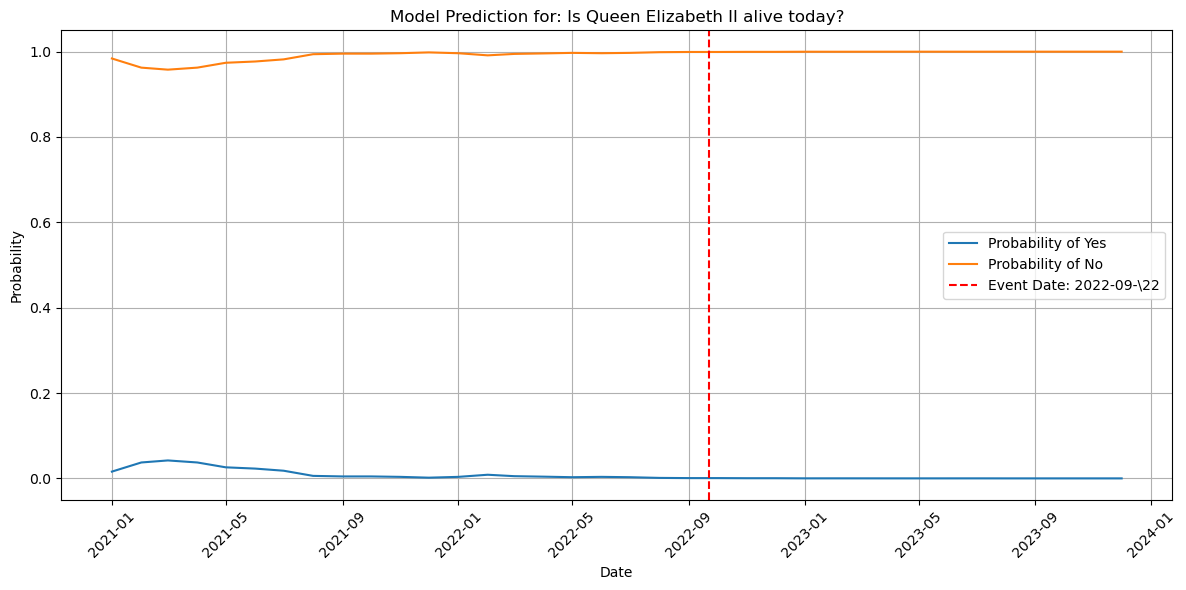

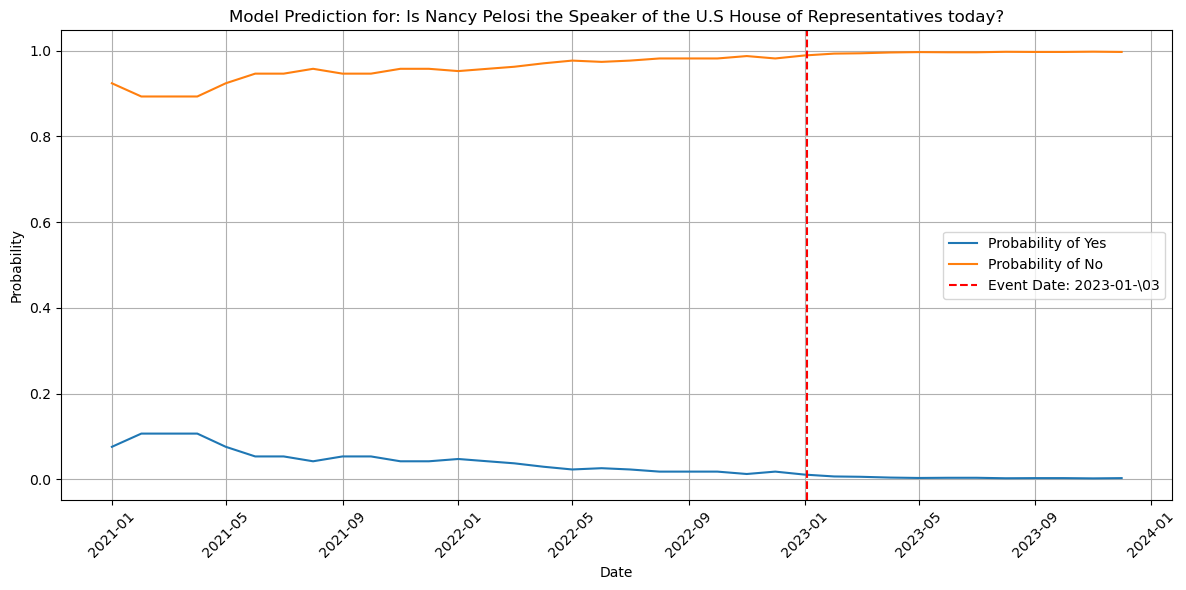

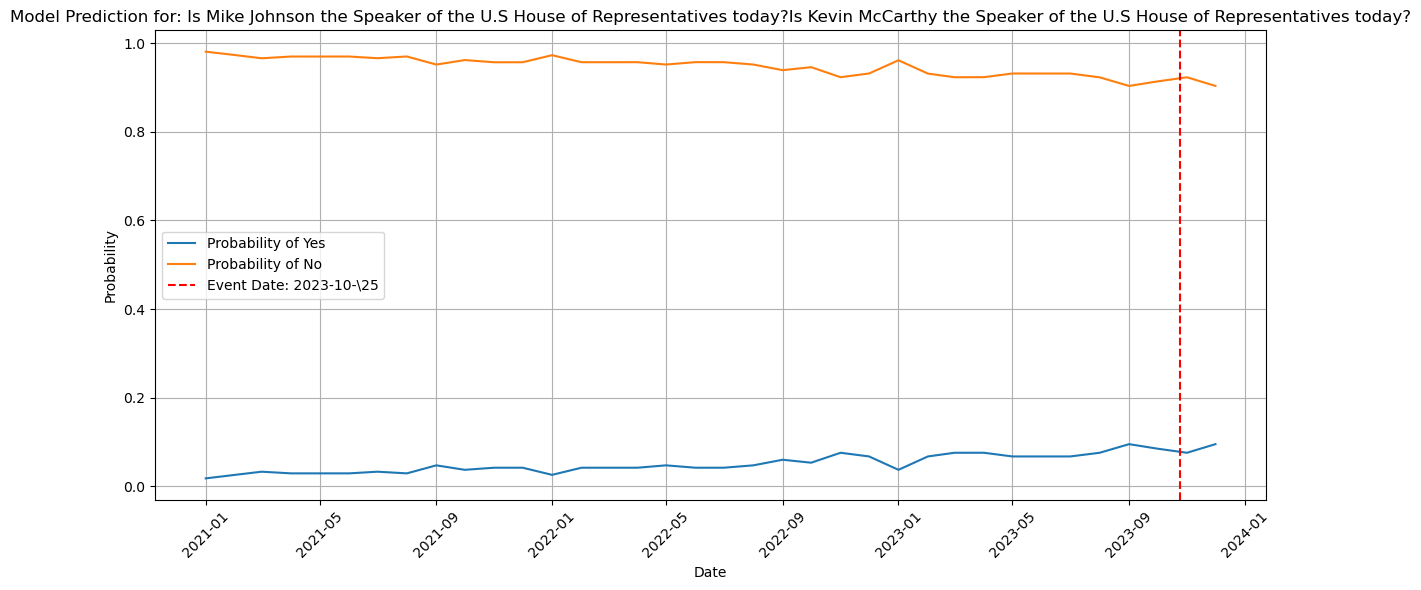

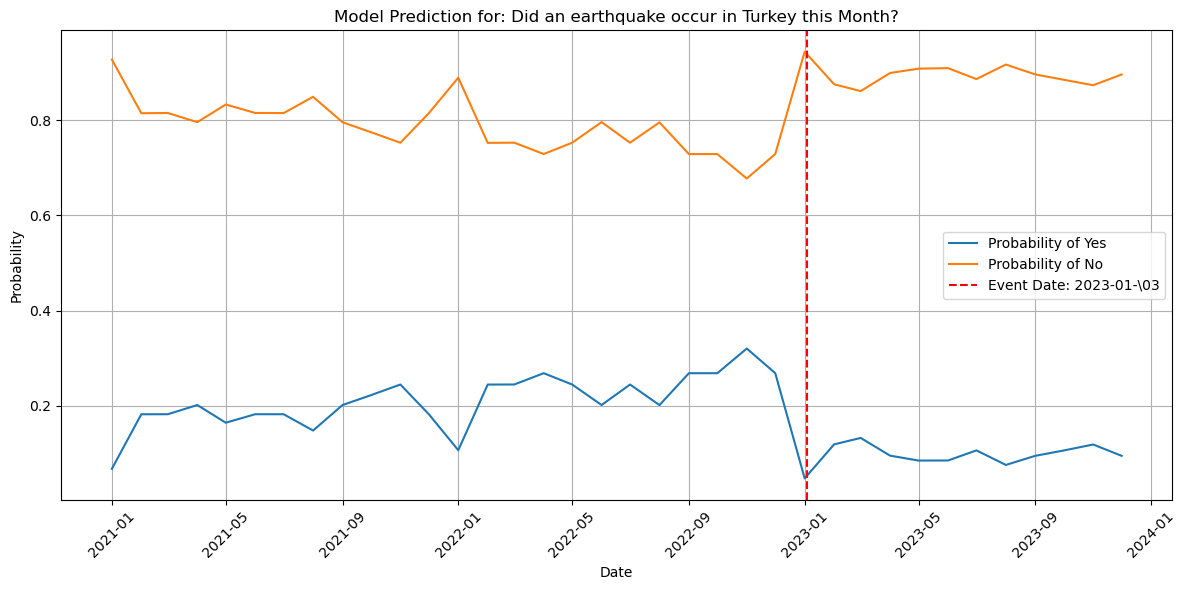

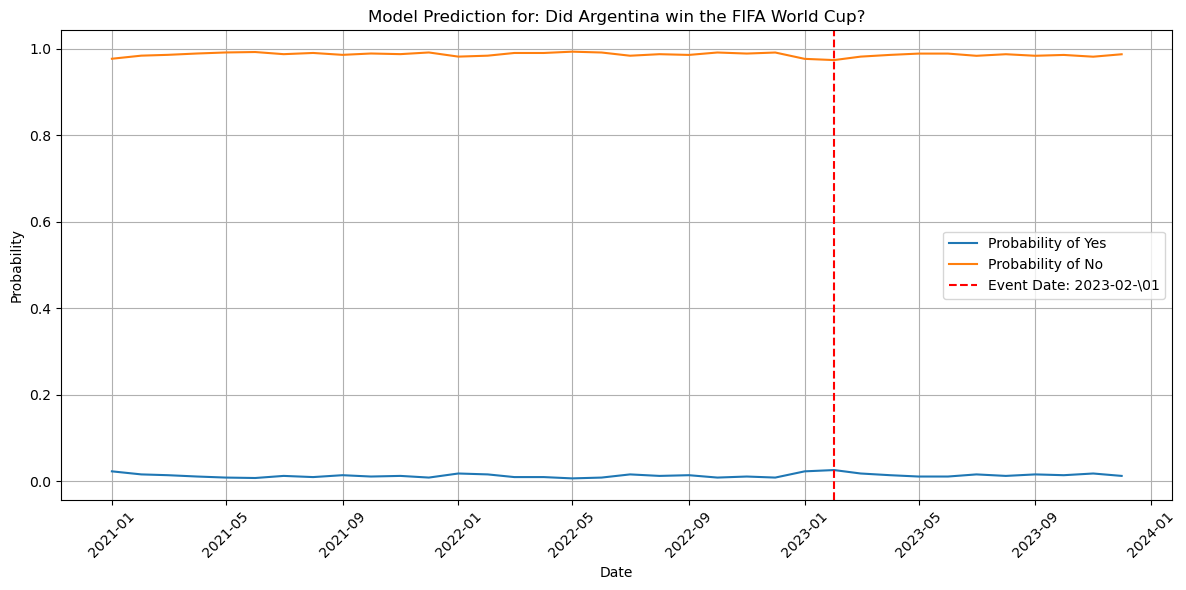

In [21]:
questions = ['Is Queen Elizabeth II alive today?','Is Nancy Pelosi the Speaker of the U.S House of Representatives today?','Is Mike Johnson the Speaker of the U.S House of Representatives today?'
             "Is Kevin McCarthy the Speaker of the U.S House of Representatives today?","Did an earthquake occur in Turkey this Month?",
             "Did Argentina win the FIFA World Cup?"]
events_dates = ["2022-09-22","2023-01-03","2023-10-25","2023-01-03","2023-02-01","2022-12-18"]

start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 1)
current_date = start_date
date_strs = []
while current_date <= end_date:
    date_strs.append(current_date.strftime("%Y-%m-%d"))
    current_date += relativedelta(months=1)

# fact_df

fact_df_2 = pd.DataFrame(columns=['date','question','yes','no','inference_time','event_date'])
fact_df_2 = fact_df_2.set_index(['question','date'])

for event_date,question in zip(events_dates,questions):

    for date_str in date_strs:
        prompt = generate_fact_prompt_2(question,date_str)
        prompt_ids = tokenizer.apply_chat_template(
                prompt,
                add_generation_prompt=True,          
                return_tensors="pt"
                ).to(model.device)
        st = time.time()
        outputs = model.generate(prompt_ids, max_new_tokens=20,
                                 do_sample=False, 
                                temperature=0.0,
                                return_dict_in_generate=True,
                                output_scores=True)
        # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
        fact_df_2.loc[(question, date_str),'inference_time'] = time.time() - st
  
        probs   = torch.softmax(outputs.scores[0], dim=-1).flatten()
        # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
        # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
        #     for w in ["Yes", "No"]})
        fact_df_2.loc[(question, date_str),"event_date"] = event_date
        fact_df_2.loc[(question, date_str),"yes"] = float(probs[tokenizer.encode("Yes", add_special_tokens=False)[0]])
        fact_df_2.loc[(question, date_str),"no"] = float(probs[tokenizer.encode("No", add_special_tokens=False)[0]])
            # print(f"Question: {question} | Date: {date_str} | Response: {response}")

fact_df_2.index = fact_df_2.index.set_levels(pd.to_datetime(fact_df_2.index.levels[1]), level='date')


fact_df_2['event_date'] = pd.to_datetime(fact_df_2['event_date'])



unique_questions = fact_df_2.index.get_level_values('question').unique()
for question in unique_questions:
    question_df = fact_df_2.loc[question]
    plt.figure(figsize=(12, 6))
    plt.plot(question_df.index, question_df['yes'], label='Probability of Yes')
    plt.plot(question_df.index, question_df['no'], label='Probability of No')

    # Get the event date for the current question
    event_date = question_df['event_date'].iloc[0]
    plt.axvline(x=event_date, color='r', linestyle='--', label=f'Event Date: {event_date.strftime("%Y-%m-\%d")}')

    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.title(f'Model Prediction for: {question}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Better demo of the issue at Hand

In [22]:

# def generate_demo_prompt(date):
#     message = [
#     {
#     "role": "system",
#     "content": 
#         f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
#     },
#     {"role": "user", "content": "What is Today's Date? Is Nancy Pelosi the Speaker of the U.S House of Representatives today? Answer in a single Word: Yes or No only.?"}
#     ]
#     return message

In [23]:
# messages = generate_prompt("Will Nancy Pelosi remain Speaker of the U.S. House of Representatives?","2022-07-01")

date = "2021-01-01"
question = "Is Nancy Pelosi the Speaker of the U.S House of Representatives today?"

message = [
    {
    "role": "system",
    "content": 
        f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
    },
    {"role": "user", "content": f"{question}? Answer in a single Word: Yes or No only. What is Today's Date?"}
    ]


prompt = tokenizer.apply_chat_template(
        message,
        # tokenize=False, # Return a string
        add_generation_prompt=True ,
        return_tensors="pt"
).to(model.device)


outputs = model.generate(prompt, max_new_tokens=100,
                                 do_sample=False, 
                                temperature=0.0,
                                )
response = tokenizer.decode(outputs[:, prompt.shape[1]:][0], skip_special_tokens=True)
print(response)

No

Today's Date: January 1, 2021


There is

In [24]:
date = "2021-01-01"
question = "Is Nancy Pelosi the Speaker of the U.S House of Representatives today?"

message = [
    {
    "role": "system",
    "content": 
        f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
    },
    {"role": "user", "content": f"What is Today's Date? {question}? Answer in a single Word: Yes or No only. "}
    ]


prompt = tokenizer.apply_chat_template(
        message,
        # tokenize=False, # Return a string
        add_generation_prompt=True ,
        return_tensors="pt"
).to(model.device)


outputs = model.generate(prompt, max_new_tokens=100,
                                 do_sample=False, 
                                temperature=0.0,
                                )
response = tokenizer.decode(outputs[:, prompt.shape[1]:][0], skip_special_tokens=True)
print(response)

Yes


# Check 3

In [25]:
def generate_fact_prompt_3(question,date):
    message = [
    {
    "role": "system",
    "content": 
        f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
    },
    {"role": "user", "content": f"What is Today's Date? {question}? Answer in a single Word: Yes or No only."}
    ]
    return message

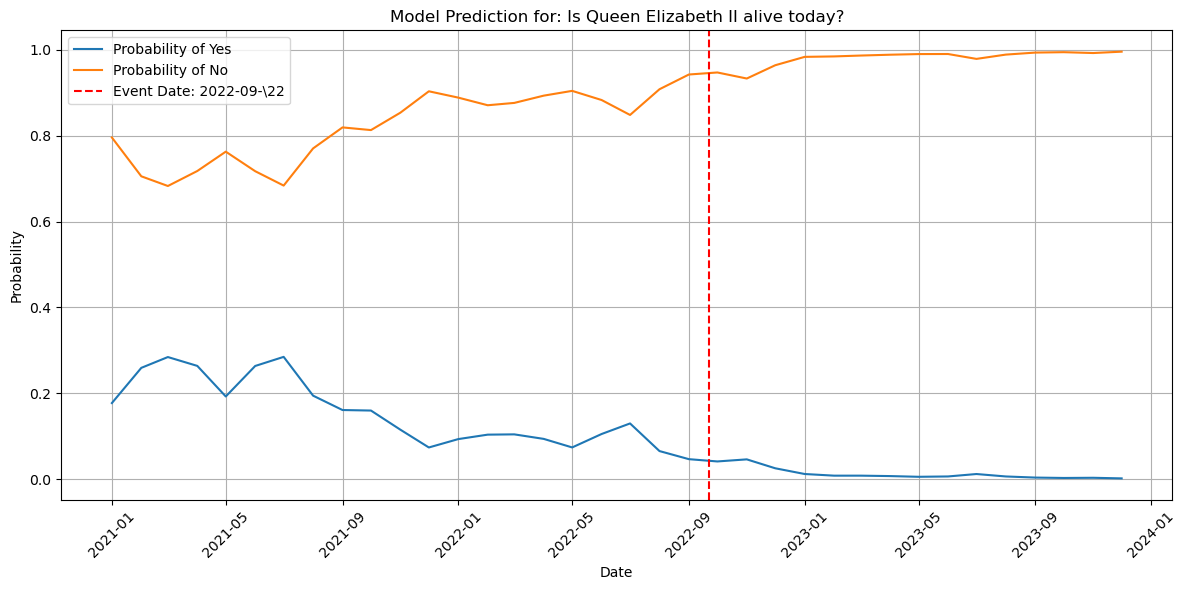

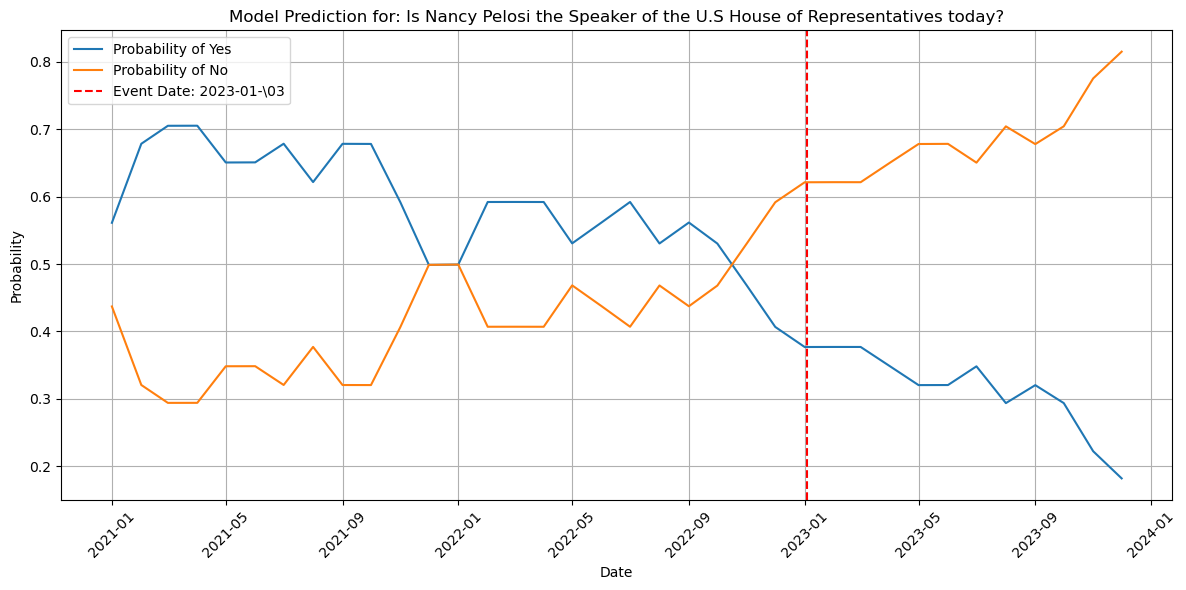

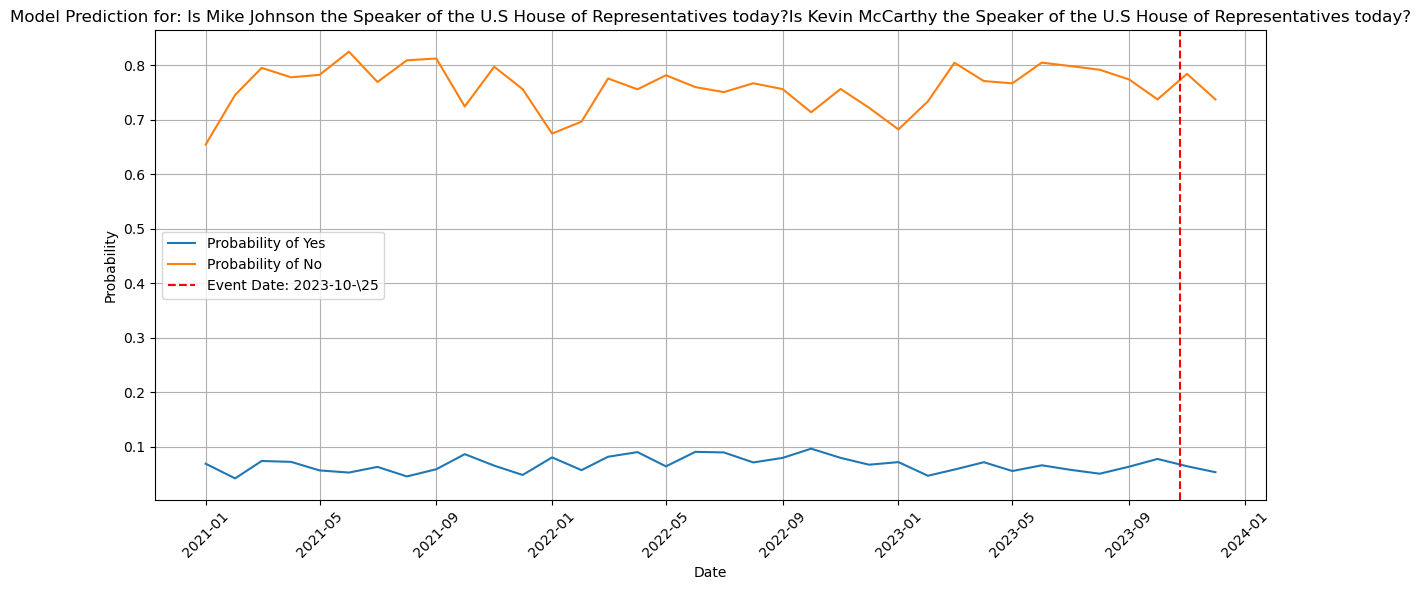

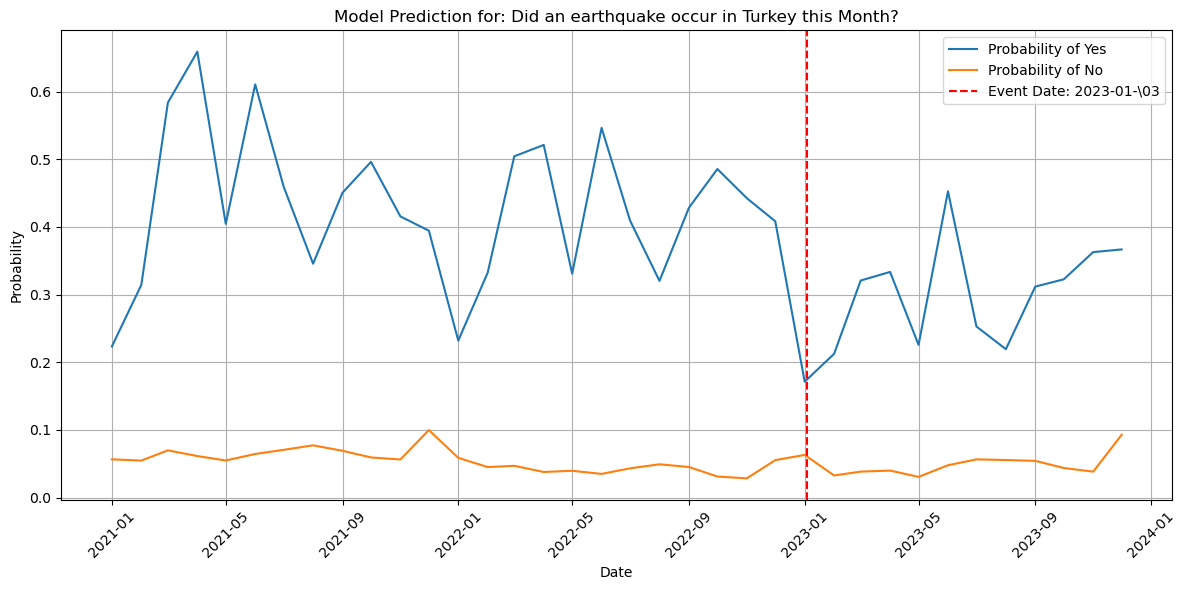

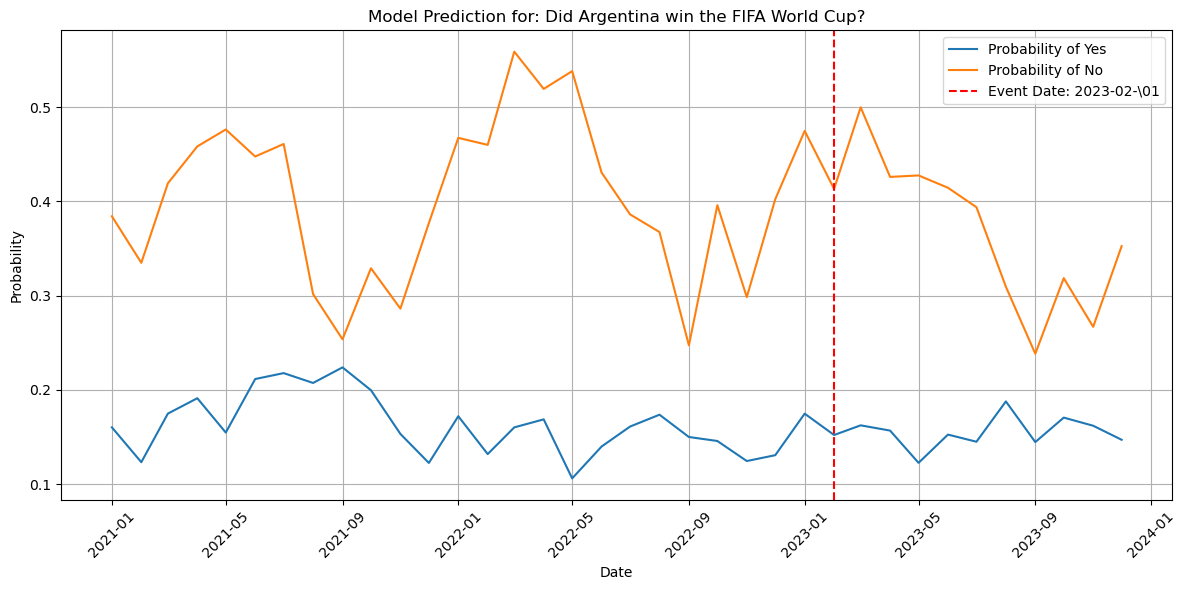

In [26]:
questions = ['Is Queen Elizabeth II alive today?','Is Nancy Pelosi the Speaker of the U.S House of Representatives today?','Is Mike Johnson the Speaker of the U.S House of Representatives today?'
             "Is Kevin McCarthy the Speaker of the U.S House of Representatives today?","Did an earthquake occur in Turkey this Month?",
             "Did Argentina win the FIFA World Cup?"]
events_dates = ["2022-09-22","2023-01-03","2023-10-25","2023-01-03","2023-02-01","2022-12-18"]

start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 1)
current_date = start_date
date_strs = []
while current_date <= end_date:
    date_strs.append(current_date.strftime("%Y-%m-%d"))
    current_date += relativedelta(months=1)

# fact_df

fact_df_2 = pd.DataFrame(columns=['date','question','yes','no','inference_time','event_date'])
fact_df_2 = fact_df_2.set_index(['question','date'])

for event_date,question in zip(events_dates,questions):

    for date_str in date_strs:
        prompt = generate_fact_prompt_3(question,date_str)
        prompt_ids = tokenizer.apply_chat_template(
                prompt,
                add_generation_prompt=True,          
                return_tensors="pt"
                ).to(model.device)
        st = time.time()
        outputs = model.generate(prompt_ids, max_new_tokens=20,
                                 do_sample=False, 
                                temperature=0.0,
                                return_dict_in_generate=True,
                                output_scores=True)
        # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
        fact_df_2.loc[(question, date_str),'inference_time'] = time.time() - st
  
        probs   = torch.softmax(outputs.scores[0], dim=-1).flatten()
        # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
        # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
        #     for w in ["Yes", "No"]})
        fact_df_2.loc[(question, date_str),"event_date"] = event_date
        fact_df_2.loc[(question, date_str),"yes"] = float(probs[tokenizer.encode("Yes", add_special_tokens=False)[0]])
        fact_df_2.loc[(question, date_str),"no"] = float(probs[tokenizer.encode("No", add_special_tokens=False)[0]])
            # print(f"Question: {question} | Date: {date_str} | Response: {response}")

fact_df_2.index = fact_df_2.index.set_levels(pd.to_datetime(fact_df_2.index.levels[1]), level='date')


fact_df_2['event_date'] = pd.to_datetime(fact_df_2['event_date'])



unique_questions = fact_df_2.index.get_level_values('question').unique()
for question in unique_questions:
    question_df = fact_df_2.loc[question]
    plt.figure(figsize=(12, 6))
    plt.plot(question_df.index, question_df['yes'], label='Probability of Yes')
    plt.plot(question_df.index, question_df['no'], label='Probability of No')

    # Get the event date for the current question
    event_date = question_df['event_date'].iloc[0]
    plt.axvline(x=event_date, color='r', linestyle='--', label=f'Event Date: {event_date.strftime("%Y-%m-\%d")}')

    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.title(f'Model Prediction for: {question}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# All in all the model is not able to answer the questions correctly. Severely limited by model power (no of parameters)